ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ № 6

Тема: Кластеризация

Группа: ПИН-б-о-22-1

Выполнил: Касимов Асхаб

#  Импорт данных


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_moons, make_circles, make_classification


# Данные

Наши старые друзья / знакомые


In [ ]:
def plot_data(ax,ds,name='',marker = 'o',colors =("#FF0000", '#0000FF'),alpha=0.7, s = 150, facecolor=True):
    X, y = ds

    cm_bright = ListedColormap(colors)
    ax.set_title(name, fontsize = 30)
    if facecolor:
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   alpha =alpha)
    else:
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   facecolor = 'None',
                   alpha =alpha)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    ax.grid(True)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

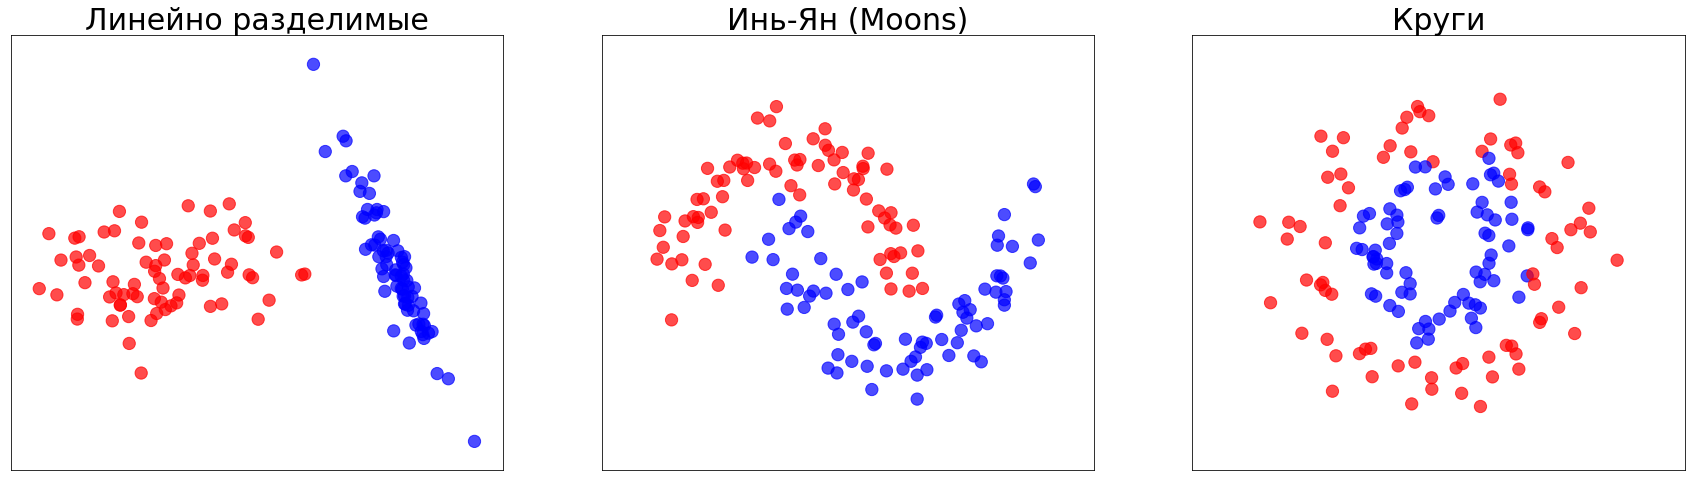

In [ ]:
#@title данные { run: "auto" }
N = 150 #@param {type:"slider", min:50, max:250, step:25}
noises = 0.15 #@param {type:"slider", min:0, max:1, step:0.05}

def make_binary_clf(N, method = 'line',
                    noises = 0.15,
                    random_state = 42):

    if random_state: rng = np.random.RandomState(seed = random_state)

    if method == 'line' or method is None:
        X, y = make_classification(n_samples=N, n_features=2,
                                   n_redundant=0, n_informative=2,
                                   n_clusters_per_class=1, class_sep=2,
                                   random_state=random_state)
        X += np.random.randn(*X.shape) *noises
        out = (X, y)

    elif method == 'moons':
        X, y = make_moons(n_samples=N, noise=noises,
                          random_state=random_state)

    elif method == 'circles':
        X, y = make_circles(n_samples=N, noise=noises, factor=0.5,
                            random_state=random_state )


    return X,y


fig=plt.figure(figsize=(30,8))

ax = plt.subplot(1, 3, 1)
plot_data(ax,make_binary_clf(N,method = 'line', noises = noises),
          'Линейно разделимые')
ax = plt.subplot(1, 3, 2)
plot_data(ax,make_binary_clf(N,method = 'moons', noises = noises),
          'Инь-Ян (Moons)')
ax = plt.subplot(1, 3, 3)
plot_data(ax, make_binary_clf(N,method = 'circles', noises = noises),
          'Круги')




## Кластеризация k-средних

В ряде случаев при анализе данных оказывается так, что про данные ничего не известно, однако хочется понять на сколько они однородны или, например, могут быть разделены на группы. Такие группы можно назвать кластерами. Задача разделения на кластеры не требует наличия учителя. Другими словами, мы пытаемся найти закономерности в данных как таковых без привязки к тому, какие результаты для них мы хотим получить.<br>

 Одним из самых простых методов кластеризации является метод k-средних.
Суть данного метода сводится к тому, чтобы найти заданное число кластеров (k) и их центры (т.н. центроиды) таких, чтобы расстояние от центроидов до всех точек кластера было минимальным.

Алгоритм k-средних может быть описан следующим образом <ul>
<li>выбирается к случайным точкам - центроиды.
<li>рассчитывается вектор расстояние между каждой точкой набора данных и каждым центроидом.
<li>в каждый кластер записываются те точки для которых оказалось, что для соответствующего центроида расстояние меньше, чем для других.
<li>новые значение центроидов рассчитываются как среднее значение по всем точкам кластера.


In [ ]:
X,y = make_binary_clf(N,method = 'line', noises=0.05, )


X.shape

(150, 2)

In [ ]:
X

array([[ 1.87567425,  2.54610401],
       [ 1.47254619,  3.5049882 ],
       [-2.40255892,  2.19963749],
       [-3.94022066,  1.49108248],
       [-3.69508347,  1.48467274],
       [ 1.67357214,  2.98986511],
       [ 2.41808705,  1.00090025],
       [-2.74894859,  0.92659707],
       [ 2.32945074,  1.2323272 ],
       [ 1.150729  ,  4.34596628],
       [ 1.80058212,  2.65723877],
       [ 1.12943838,  4.05591189],
       [ 0.72679219,  5.62976712],
       [ 1.24475558,  4.1064797 ],
       [-1.46734334,  2.43954645],
       [ 1.64546066,  2.79298213],
       [-1.01093308,  1.70536929],
       [ 1.40572256,  3.30289333],
       [-0.65736175,  2.6481394 ],
       [ 2.39806806,  1.02362532],
       [ 2.35905683,  1.04993244],
       [ 1.82515668,  2.467441  ],
       [ 1.8778621 ,  2.34707419],
       [ 2.11648141,  1.64054388],
       [ 2.59849853,  0.39396494],
       [-2.58596906,  0.31947703],
       [-3.8575931 ,  2.50369303],
       [-2.18458238,  1.29395357],
       [ 2.08961296,

Рассчитаем расстояние как сумму разностей квадратов.

In [ ]:
def distance(X1, X2, metric = 'euclidean', p = 2):
    if metric == 'euclidean':
        dist = np.sqrt(np.sum(np.square(X1 - X2).T,axis=0))
    if metric == 'cityblock':
        dist = np.sum(np.abs(X1 - X2).T,axis=0)
    if metric == 'Chebyshev':
        dist = np.max(np.abs(X1 - X2).T,axis=0)
    if metric == 'Minkowski':
        dist = np.power(np.sum(np.power(np.abs(X1 - X2),p).T,axis=0),1/p)
    return dist

Проведем несколько тестов, функция работает как с векторами, так и матрицами равной размерности.

In [ ]:
X[:5]

array([[ 1.87567425,  2.54610401],
       [ 1.47254619,  3.5049882 ],
       [-2.40255892,  2.19963749],
       [-3.94022066,  1.49108248],
       [-3.69508347,  1.48467274]])

In [ ]:
X[10:15]

array([[ 1.80058212,  2.65723877],
       [ 1.12943838,  4.05591189],
       [ 0.72679219,  5.62976712],
       [ 1.24475558,  4.1064797 ],
       [-1.46734334,  2.43954645]])

In [ ]:
print(distance(X[0], X[1],metric = 'cityblock'))
print(distance(X[:5], X[10:15]))
print(distance(X[0], X[10:15]))

1.362012247285372
[0.13412593 0.64902995 4.64312693 5.80726108 2.42375945]
[0.13412593 1.68415789 3.29073064 1.6831015  3.34471541]


In [ ]:
metrics = ['euclidean','cityblock','Chebyshev','Minkowski']

In [ ]:
for metric in metrics:
    print(distance(X[0], X[1],metric = metric, p = 10))

1.040178404910538
1.362012247285372
0.9588841842777032
0.95890072297165


Прежде чем проводить кластеризацию необходимо проинициализировать калстеры.<br>
Для этого выберем случайные индексы среди доступных в наборе данных.

In [ ]:
def init_centroids(X, n_clusters, random_state = 42):
    if random_state: rng = np.random.seed(random_state)
    centroid_idxs = np.random.randint(0, X.shape[0], size = n_clusters)
    return X[centroid_idxs,:]


посмотрим как это работает для двух кластеров

In [ ]:
n_clusters = 2
centroids = init_centroids(X, n_clusters)
print(centroids)

[[-2.46577223  2.34077181]
 [ 1.85634264  2.52105198]]


Проведем первую кластеризацию. Для этого возьмем каждый центроид и посчитаем расстояние от него до все записей набора данных. <br>
Индексы значений для каждого кластера выберем как индексы минимальных расстояний до соответствующего центроида. <br>
Таким образом, нулевой кластер будет включать те точки набора данных, в которых расстояние до нулевого центроида меньше, чем до первого центроида.

In [ ]:
def predict(X, n_clusters, centroids, metric = 'euclidean', p = 2):
    distances = np.zeros((X.shape[0], n_clusters))

    for i,centr in enumerate(centroids):
        distances[:,i] = distance(centr,X, metric, p)

    cluster_label = np.argmin(distances,axis = 1)
    return cluster_label, distances

посмотрим как распределились результаты кластеризации

Для этого бахнем функцию (чтобы не повторятся)

In [ ]:
def plot_cluster(X,centroids, cluster_label, centroids_label, old_centroids = None, old_centroids_label = None):

    fig = plt.figure(figsize=(11,10))

    plt.scatter(X[:, 0], X[:, 1],
                c = cluster_label, cmap = 'bwr',
                s=100,alpha = 0.6)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                c = centroids_label, cmap = 'bwr',
                s=400, edgecolors = 'k')

    if old_centroids is not None:
        plt.scatter(old_centroids[:, 0], old_centroids[:, 1],
            c = old_centroids_label, cmap = 'bwr',
            s=200, edgecolors = 'k')

    plt.xticks([])
    plt.yticks([])

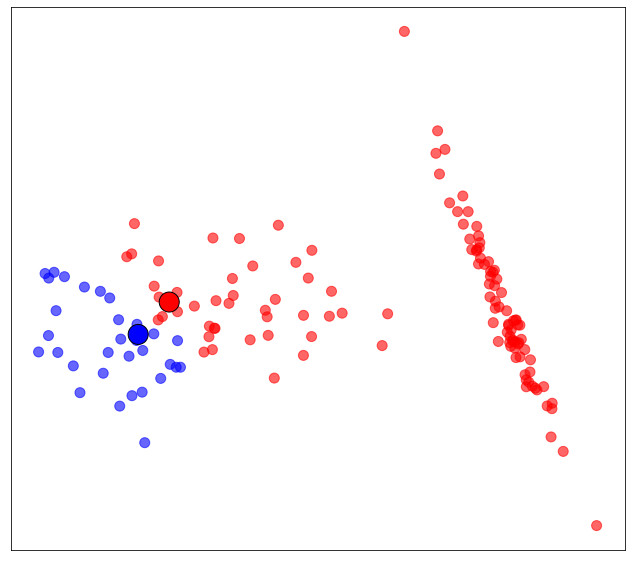

In [ ]:
centroids = init_centroids(X, n_clusters, random_state=32)

cluster_label, distances=predict(X, n_clusters, centroids)
centroids_label = [0,1]

plot_cluster(X,centroids,
             cluster_label, centroids_label,)

Теперь выберем новые центроиды, для этого нам понадобиться выбрать каждый кластер по отдельности

In [ ]:
old_centroids = np.copy(centroids)

for k in range(n_clusters):
    c_idxs = np.flatnonzero(cluster_label==k)
    centroids[k] = X[c_idxs].mean(axis = 0)

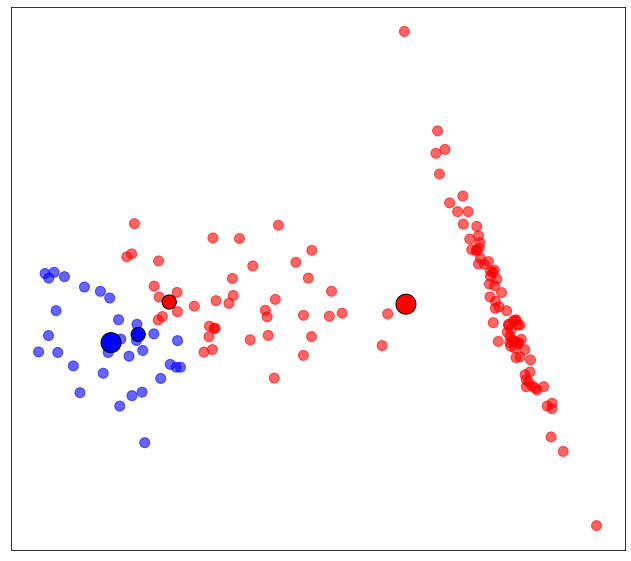

In [ ]:
plot_cluster(X,centroids,
             cluster_label, centroids_label,
             old_centroids, centroids_label)

Рассчитаем относительное расстояние между старыми и новыми центроидами. Если расстояние между обновленными центроидами будет сравнительно небольшим - то есть центроиды перестанут менять позицию, то мы будем считать что кластеризация закончена.

In [ ]:
def delta_centroids(centroids,old_centroids, metric = 'euclidean', p = 2):
    return (distance(centroids,old_centroids, metric, p)/distance(old_centroids, np.mean(old_centroids), metric, p)).mean()

delta_centroids(centroids,old_centroids)

0.5405352776426792

Попробуем создать процедуры итерационной кластеризации. В кноце процедуры выведем результирующий номер итерации и расстояние между кластерами

In [ ]:
def fit(X, n_clusters, centroids, max_iter=10, tol=0.01, metric = 'euclidean', p = 2):

    dcentr = np.inf

    for i in range(max_iter):

        old_centroids = np.copy(centroids)
        cluster_label,_=predict(X, n_clusters, centroids, metric, p)

        for k in range(n_clusters):
            c_idxs = np.flatnonzero(cluster_label==k)
            centroids[k] = X[c_idxs].mean(axis = 0)

        dcentr = delta_centroids(centroids,old_centroids, metric, p)

        if dcentr<=tol:
            break

    print('Мы остановились на итерации:', i,', относительное изменение центроидов: ',dcentr)

    return cluster_label

проверим и визуализируем результаты:

In [ ]:
cluster_label = fit(X, n_clusters, centroids, max_iter=100, tol=0.001)

Мы остановились на итерации: 5 , относительное изменение центроидов:  0.0


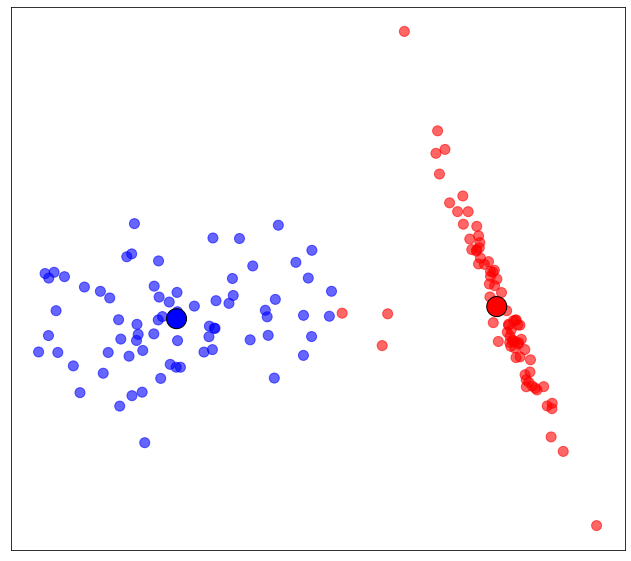

In [ ]:

plot_cluster(X,centroids,
             cluster_label, centroids_label,)

# ООП

Теперь объеденим все наши наработки в один класс.

In [ ]:
class KMeans():
    def __init__(self,n_clusters = 2, centroids = None,
                 max_iter=10, tol=0.01,
                 metric = 'euclidean', p = 2,
                 random_state = None):
        self.n_clusters = n_clusters
        self.centroids  = centroids
        self.max_iter   = max_iter
        self.tol        = tol
        self.iters      = None
        self.inertia = None
        self.metric = metric
        self.p  = p
        self.random_state  = random_state
    #-------------------------------------
    def distance(self,X1, X2):
        if self.metric == 'euclidean':
            dist = np.sqrt(np.sum(np.square(X1 - X2).T,axis=0))
        if self.metric == 'cityblock':
            dist = np.sum(np.abs(X1 - X2).T,axis=0)
        if self.metric == 'Chebyshev':
            dist = np.max(np.abs(X1 - X2).T,axis=0)
        if self.metric == 'Minkowski':
            dist = np.power(np.sum(np.power(np.abs(X1 - X2),self.p).T,axis=0),1/self.p)
        return dist
    #-------------------------------------
    def init_centroids(self, X):
        if self.random_state: rng = np.random.seed(self.random_state)
        c_idxs = np.random.randint(0, X.shape[0], size = self.n_clusters)
        return X[c_idxs,:]
    #-------------------------------------
    def predict(self, X):
        distances = np.zeros((X.shape[0], self.n_clusters))

        for i,centr in enumerate(self.centroids):
            distances[:,i] = self.distance(centr,X)
        self.inertia = np.sum(np.power(np.min(distances,axis = 1),2))
        return np.argmin(distances,axis = 1)
    #-------------------------------------
    def transform(self,X):
        return self.predict(X)
    #-------------------------------------
    def delta_centroids(self,old_centroids):
        return (
                distance(self.centroids,old_centroids)/
                distance(old_centroids, np.mean(old_centroids))
               ).mean()
    #-------------------------------------
    def fit(self, X):

        if self.centroids is None:
            self.centroids = self.init_centroids(X)

        d_centrs = np.inf

        for i in range(self.max_iter):

            old_centroids = np.copy(self.centroids)

            cluster_label = self.predict(X)

            for k in range(self.n_clusters):

                c_idxs = np.flatnonzero(cluster_label==k)

                self.centroids[k] = X[c_idxs].mean(axis = 0)

            d_centrs = self.delta_centroids(old_centroids)

            self.iters = i
            if d_centrs<=self.tol:
                break
        return self
    #-------------------------------------
    def fit_transform(self, X):
        return self.fit(X).predict(X)



Посмотрим метод локтя

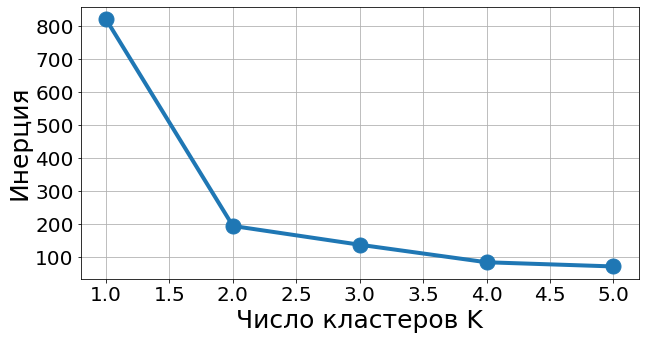

In [ ]:
sse = []
list_k = list(range(1, 6))
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia)

plt.figure(figsize=(10, 5))
plt.plot(list_k, sse, '-o',
         linewidth = 4, markersize = 15)
plt.xlabel('Число кластеров K', fontsize = 25)
plt.ylabel('Инерция', fontsize = 25)

plt.grid();
plt.xticks(FontSize = 20)
plt.yticks(FontSize = 20);

Посмотрим для 2 кластеров

Мы остановились на итерации:: 3


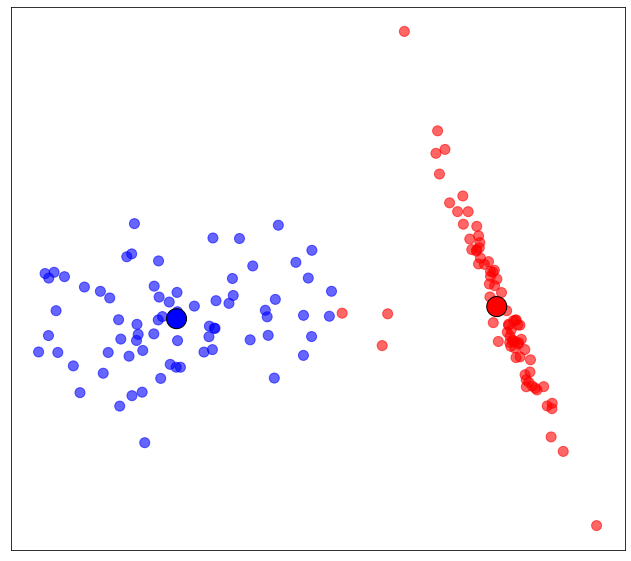

In [ ]:
kmeans   = KMeans(n_clusters=2,max_iter=100, tol=0.01, random_state= 42)
c_labels = kmeans.fit_transform(X)

print('Мы остановились на итерации::',kmeans.iters)


plot_cluster(X,kmeans.centroids,
             c_labels, np.unique(c_labels),)

Посмотрим для 4 кластеров

Мы остановились на итерации:: 2


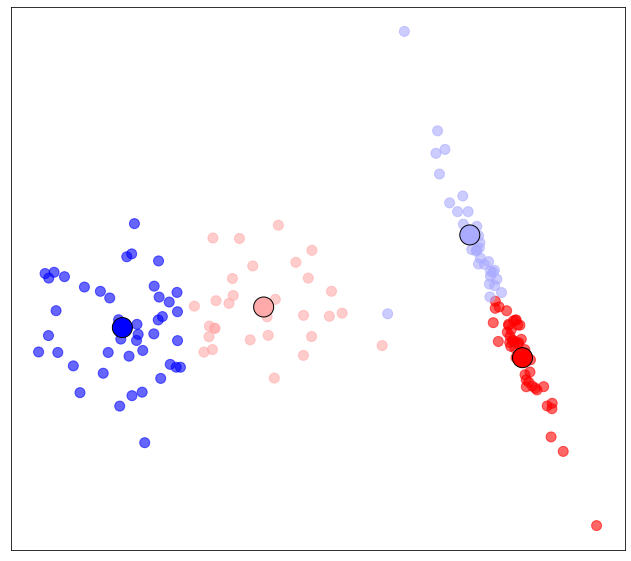

In [ ]:
kmeans   = KMeans(n_clusters=4,max_iter=100, tol=0.01, random_state= 42)
c_labels = kmeans.fit_transform(X)

print('Мы остановились на итерации::',kmeans.iters)


plot_cluster(X,kmeans.centroids,
             c_labels, np.unique(c_labels),)

Немного о метриках

In [ ]:
pd.crosstab(y,c_labels, rownames=['Метки'], colnames = ['Предсказания'])

Предсказания   0   1   2   3
Метки                       
0             43   1  31   0
1              0  31   0  44

Контрольные вопросы

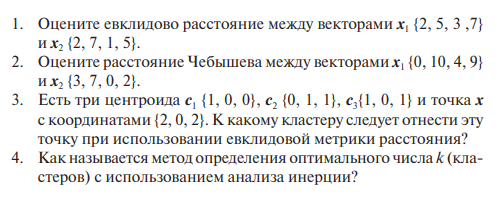

1. 3,464

2. 7

3. К третьему кластеру

4. Метод k-средних